In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"
exp = "sparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11
config["freeze_params"] = "output"

# config["boost_strength"] = 0.0
# config["boost_strength_factor"] = 0.0

experiment = ContinuousSpeechExperiment(config=config)

model on GPU
Creating optimizer with learning rate= 0.01


In [ ]:
accs = [] # test loss
ent = [] # entropy
class_acc = []
t_acc = []
grads = []

np.random.seed(np.random.randint(0,100))
train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))

epochs = 1
indices = []


for label in train_labels:
    print("training on class {}".format(label))
    
    indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])
    print("Frozen weight indices: {}".format(indices)) 
    
    for epoch in range(epochs):
        print("training: epoch {}".format(epoch+1))
        experiment.train(epoch, label, indices)   
            
        print(torch.max(experiment.model.output.weight.grad[indices,:]))
        
        mt = experiment.test()
        t_acc.append(mt["mean_accuracy"])

        grads.append(experiment.model.output.weight.grad.cpu().numpy())

    ct = [experiment.test_class(k)["mean_accuracy"] for k in range(1,11)]
    class_acc.append(ct)

    t = experiment.test()
    print("Mean accuracy: {}".format(t["mean_accuracy"]))
    accs.append(t["mean_accuracy"])
    ent.append(np.round(t["entropy"]))
    

training on class [1 2]
Frozen weight indices: [ 0  3  4  7  5  8  9 10  6]
training: epoch 1


/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


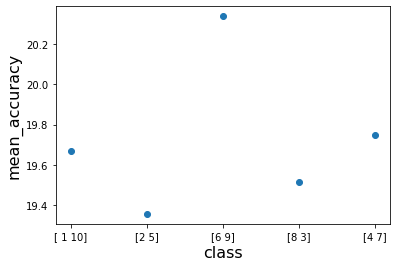

In [370]:
plt.plot(accs,'o')
plt.xlabel('class', fontsize=16)
plt.ylabel('mean_accuracy', fontsize=16)
plt.xticks(range(5),labels=train_labels);
# plt.ylim((5.,25.));

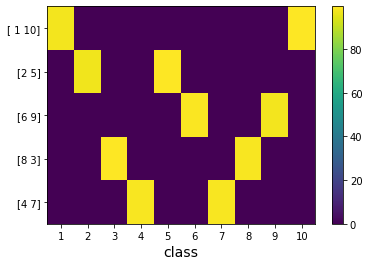

In [371]:
plt.imshow(class_acc, aspect="auto")
plt.yticks(range(5),labels=train_labels)
plt.xticks(range(10), range(1,11));
plt.xlabel("class", fontsize=14)
plt.colorbar();

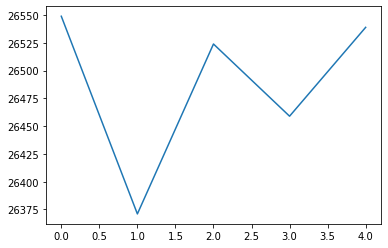

In [372]:
plt.plot(ent)

In [307]:
experiment.model.cnn1_kwinner.forward()

KWinners2d(channels=64, local=False, n=50176, percent_on=0.095, boost_strength=0.0, boost_strength_factor=0.0, k_inference_factor=1.0, duty_cycle_period=1000)

In [373]:
ys = []
for k in range(1,11):
    l = experiment.test_loader[k]
    x,y = next(iter(l))
    ys.append(experiment.model.cnn1_kwinner(experiment.model.cnn1_cnn(x.cuda())).detach().cpu().numpy().flatten())

In [378]:
experiment.model.cnn1_kwinner

KWinners2d(channels=64, local=False, n=50176, percent_on=0.095, boost_strength=0.8857348561286926, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)

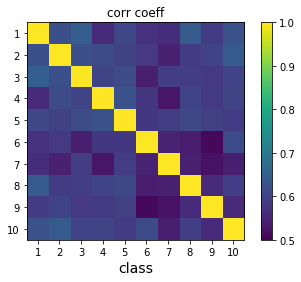

In [377]:
plt.imshow(np.corrcoef(Y))
plt.clim((0.5, 1.))
plt.xticks(range(10), range(1,11))
plt.yticks(range(10), range(1,11))
plt.xlabel("class", fontsize=14)
plt.title("corr coeff")
plt.colorbar()

In [486]:
act = {}
def get_act(name):
    def hook(model, input_, output):
        act[name] = output.detach().cpu().numpy()
    return hook

model = experiment.model

In [488]:
cnt = 0
layer_list = list(model.named_children())
k = [x[0] for x in layer_list]

for module in model:
    module.register_forward_hook(get_act(k[cnt]))
    cnt += 1
    
outputs = []
for k in range(1,11):
    act = {}
    loader = experiment.test_loader[k]
    x,_ = next(iter(loader))
    model(x.cuda())
    outputs.append(act)

In [494]:
all_keys = outputs[0].keys()

In [547]:
cnnk1 = [np.vstack([x['cnn1_kwinner'][k,:,:,:].flatten() for k in range(32)]) for x in outputs]

In [566]:
iu = np.triu_indices(32,32)
np.corrcoef(cnnk1[0])[iu].mean()

0.18224042892906764

In [567]:
cnnk1[0].shape

(32, 50176)

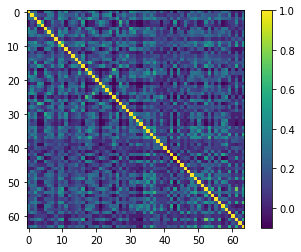

In [572]:
plt.imshow(np.corrcoef(cnnk1[0],cnnk1[1]))
plt.colorbar()

In [607]:
corr_mat = np.full((10,10),np.nan)
iu = np.triu_indices(32,1)

for i in range(10):
    for j in range(10):
        corr_mat[i,j] = np.corrcoef(cnnk1[i], cnnk1[j])[iu].mean()
        

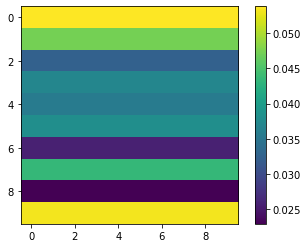

In [608]:
plt.imshow(corr_mat)
plt.colorbar()

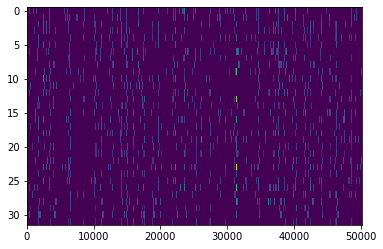

In [587]:
plt.imshow(cnnk1[1], aspect="auto")

In [600]:
np.triu_indices?

In [614]:
np.corrcoef(cnnk1[5], cnnk1[1])[iu].mean()

0.12887544757289893

array([[0.18224043, 0.18224043, 0.18224043, 0.18224043, 0.18224043,
        0.18224043, 0.18224043, 0.18224043, 0.18224043, 0.18224043],
       [0.16552289, 0.16552289, 0.16552289, 0.16552289, 0.16552289,
        0.16552289, 0.16552289, 0.16552289, 0.16552289, 0.16552289],
       [0.12803431, 0.12803431, 0.12803431, 0.12803431, 0.12803431,
        0.12803431, 0.12803431, 0.12803431, 0.12803431, 0.12803431],
       [0.14041547, 0.14041547, 0.14041547, 0.14041547, 0.14041547,
        0.14041547, 0.14041547, 0.14041547, 0.14041547, 0.14041547],
       [0.12759518, 0.12759518, 0.12759518, 0.12759518, 0.12759518,
        0.12759518, 0.12759518, 0.12759518, 0.12759518, 0.12759518],
       [0.12887545, 0.12887545, 0.12887545, 0.12887545, 0.12887545,
        0.12887545, 0.12887545, 0.12887545, 0.12887545, 0.12887545],
       [0.10424437, 0.10424437, 0.10424437, 0.10424437, 0.10424437,
        0.10424437, 0.10424437, 0.10424437, 0.10424437, 0.10424437],
       [0.16355467, 0.16355467, 0.1635546